In [82]:
import numpy as np
import pandas as pd
from scipy import stats, fft
from matplotlib import pyplot as plt
from skimage import io, restoration, color, filters
import cv2
from numpy.typing import NDArray
import pywt
from numpy.fft import fft2, ifft2, fftshift, ifftshift


In [83]:
def poissoning(image: NDArray, lambda_value: float) -> np.ndarray: #szum
    noised_image = np.random.poisson(image / image.max() * lambda_value) / lambda_value
    noised_image = np.clip(noised_image * 255, 0, 255).astype(int)
    return noised_image


In [84]:
def anscombe(x):
    c = 3 / 8
    return 2 * np.sqrt(x + c)
def inv_anscombe(y):
    c = -1 * 3 / 8
    return np.power(0.5 * y, 2) + c
def depoisson(image): #odszumianie
    x = image / image.max()
    x = anscombe(x)
    x = restoration.denoise_tv_chambolle(x) 
    x = inv_anscombe(x)
    return x

In [85]:
def fft_based_denoising(imageg, threshold_percent):
    f_transform = fft2(imageg)     #transformacja Fouriera 
    f_transform_shifted = fftshift(f_transform)    #przesunięcie obrazu
    magnitude_spectrum = np.abs(f_transform_shifted)    #magnituda i progowanie
    threshold = np.percentile(magnitude_spectrum, threshold_percent)
    f_transform_shifted[np.abs(magnitude_spectrum) < threshold] = 0
    f_transform_back = ifftshift(f_transform_shifted)    #przesunięcie spowrotem
    denoised_imageg = np.abs(ifft2(f_transform_back))    #odwrotna transformacja Fouriera

    return denoised_imageg

In [86]:
def fft_based_denoising_color(image, threshold_percent):
    denoised_image = np.zeros_like(image, dtype=np.float64)    #pusta macierz na odszumiony obraz
    for channel in range(image.shape[2]):    #dla każdego kanału wykonaj odszumianie
        f_transform = fft2(image[:, :, channel])        #transformacja Fouriera 
        f_transform_shifted = fftshift(f_transform)        #przesunięcie obrazu
        magnitude_spectrum = np.abs(f_transform_shifted)         #magnituda i progowanie
        threshold = np.percentile(magnitude_spectrum, threshold_percent)
        f_transform_shifted[np.abs(magnitude_spectrum) < threshold] = 0
        f_transform_back = ifftshift(f_transform_shifted)        #przesunięcie spowrotem
        denoised_channel = np.abs(ifft2(f_transform_back))        #odwrotna transformacja Fouriera
        denoised_image[:, :, channel] = denoised_channel        #dodaj odszumiony kanał do końcowego

    return denoised_image.astype(np.uint8)

In [ ]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
y = np.sin(x) + np.sin(4 * x) + stats.norm.rvs(size=1000, loc=0, scale=0.1)
plt.plot(x, y)
transformed = fft.fft(y)
transformed.shape, transformed.dtype
freqs = fft.fftfreq(len(y))
plt.plot(np.sort(freqs), np.abs(transformed))
plt.plot(np.sort(freqs)[600:1000], np.abs(transformed)[600:1000])
threshold = 0.5 * np.abs(transformed).max()
index = (np.abs(transformed) <= threshold)
index.shape, index.dtype
transformed[index] = 0 + 0j
denoised = fft.ifft(transformed)
denoised.shape, denoised.dtype
plt.plot(np.real(denoised))

(-0.5, 504.5, 358.5, -0.5)

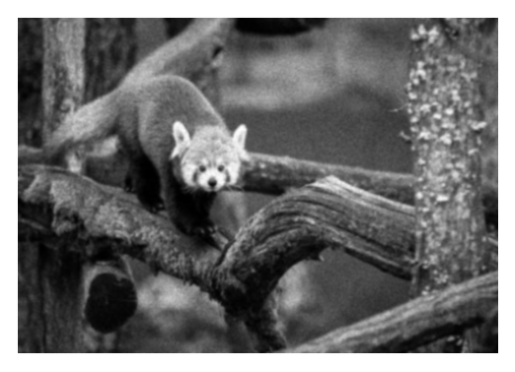

In [87]:
#szare odszumianie 1
image_path = "C:/Users/matiu/OneDrive/Pulpit/SIOC/lab4/szare/image.jpg"
image = cv2.imread(image_path)
plt.imshow(image, cmap='gray')
plt.axis('off')


(-0.5, 504.5, 358.5, -0.5)

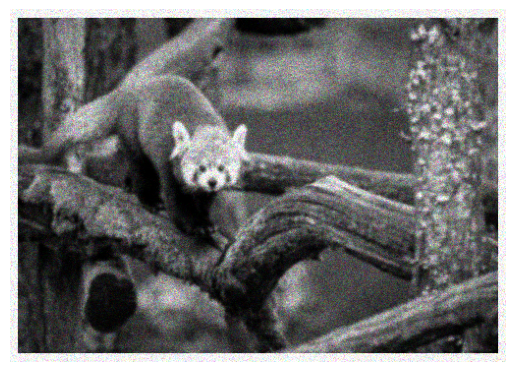

In [88]:
noised_image = poissoning(image, lambda_value=64)#symulacja szumu
plt.imshow(noised_image, cmap='gray')
plt.axis('off')

(-0.5, 504.5, 358.5, -0.5)

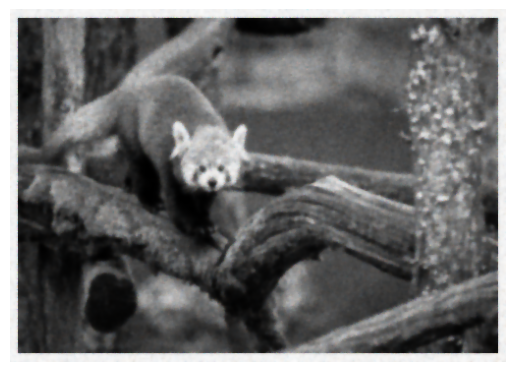

In [89]:
transformed_image = depoisson(noised_image) #odszumione
plt.imshow(transformed_image, cmap='gray')
plt.axis('off')

(-0.5, 504.5, 358.5, -0.5)

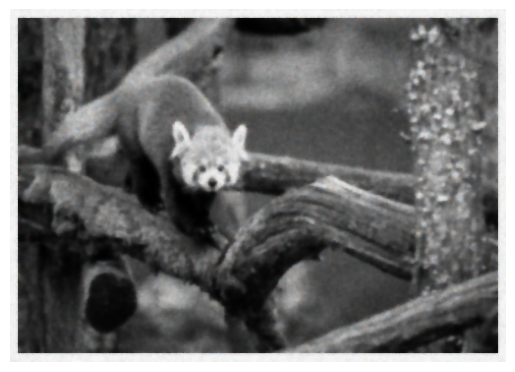

In [79]:
#szare odszumianie 2
#procent punktów, które mają zostać zachowane
threshold_percent = 10
# transformacja Fouriera
denoised_imageg = fft_based_denoising(noised_image, threshold_percent)
plt.imshow(denoised_imageg, cmap='gray')
plt.axis('off')

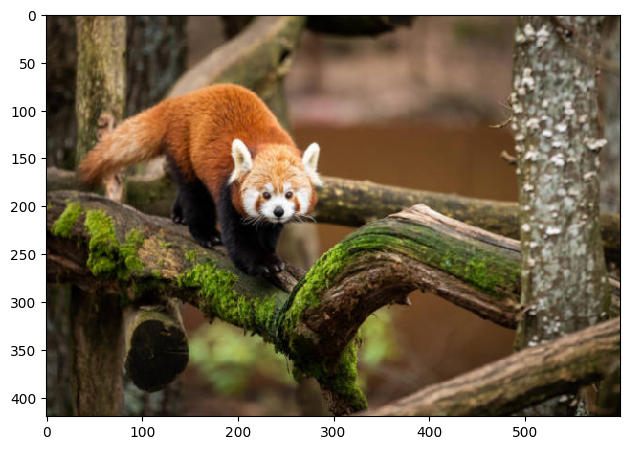

In [90]:
#odszumianie kolor 2
#na .jpg
# image_path = "C:/Users/matiu/OneDrive/Pulpit/SIOC/lab4/kolorowe/panda.jpg"
# image = cv2.imread(image_path)
# plt.imshow(image)
# plt.axis('off')
#na przykładowym .npy
image1 = np.load("C:/Users/matiu/Downloads/CFA_NPY/CFA_NPY/Fuji/panda.npy")
io.imshow(image1)

(-0.5, 599.5, 419.5, -0.5)

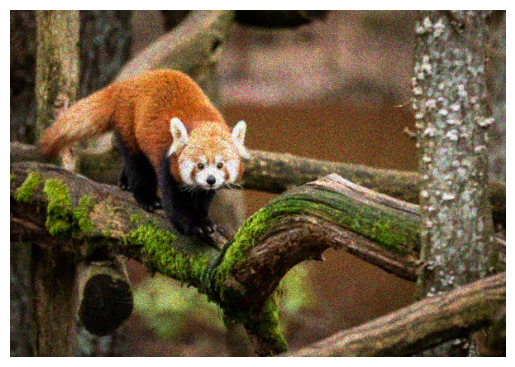

In [91]:
noised_image1 = poissoning(image1, lambda_value=64)#symulacja szumu
plt.imshow(noised_image1)
plt.axis('off')

(-0.5, 599.5, 419.5, -0.5)

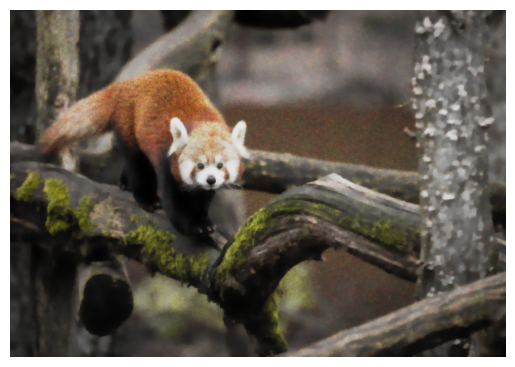

In [92]:
transformed_image1 = depoisson(noised_image1)#odszumione 
plt.imshow(transformed_image1)
plt.axis('off')

(-0.5, 599.5, 419.5, -0.5)

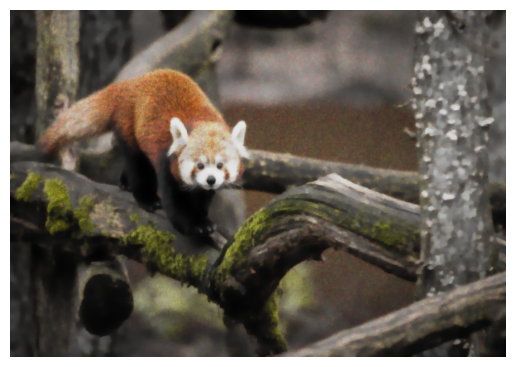

In [76]:
#odszumianie kolor 2
threshold_percent = 10  #procent punktów które mają zostać zachowane

# transformacja Fouriera po jednej na każdy kanał
denoised_color_image = fft_based_denoising_color(noised_image1, threshold_percent)
plt.imshow(denoised_color_image)
plt.axis('off')

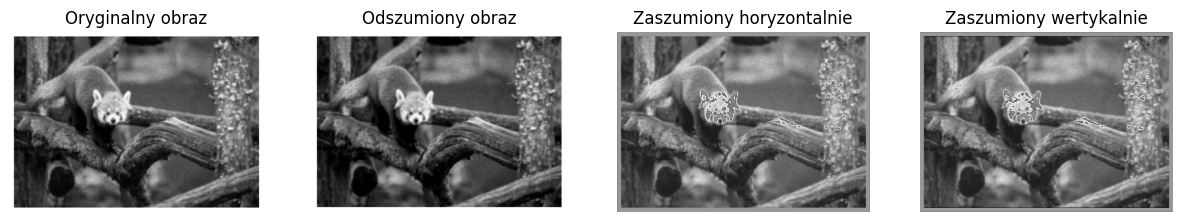

In [93]:
#odszumianie falkowe 
image_path = "C:/Users/matiu/OneDrive/Pulpit/SIOC/lab4/szare/image.jpg"
original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
wavelet = 'db1' #wybierz rodzaj transformacji falkowej(haar, db1, bior2.2)
coeffs2 = pywt.dwt2(original, wavelet)  #dwuwymiarowa transformacja falkową
LL, (LH, HL, HH) = coeffs2
threshold = 20  #prog dla usuwania szumu
LL_thresholded = pywt.threshold(LL, threshold, mode='soft') #prgowanie współczynników falkowych
LH_thresholded = pywt.threshold(LH, threshold, mode='soft')
HL_thresholded = pywt.threshold(HL, threshold, mode='soft')
HH_thresholded = pywt.threshold(HH, threshold, mode='soft')
coeffs_thresholded = (LL_thresholded, (LH_thresholded, HL_thresholded, HH_thresholded))
reconstructed_image = pywt.idwt2(coeffs_thresholded, wavelet) #rekonstrukcja obrazu przekształconymi współczynnikami
#sztuczne testowe zaszumienie horyzontalnie
noisy_image_horizontal = original.copy()
noisy_image_horizontal[:, ::2] += 50  #szum co drugi piksel
#sztuczne testowe zaszumianie wertykalnie
noisy_image_vertical = original.copy()
noisy_image_vertical[::2, :] += 50  #szum co drugi piksel

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(original, cmap=plt.cm.gray)
axes[0].set_title('Oryginalny obraz')
axes[0].axis('off')
axes[1].imshow(reconstructed_image, cmap=plt.cm.gray)
axes[1].set_title('Odszumiony obraz')
axes[1].axis('off')
axes[2].imshow(noisy_image_horizontal, cmap=plt.cm.gray)
axes[2].set_title('Zaszumiony horyzontalnie')
axes[2].axis('off')
axes[3].imshow(noisy_image_vertical, cmap=plt.cm.gray)
axes[3].set_title('Zaszumiony wertykalnie')
axes[3].axis('off')
plt.show()


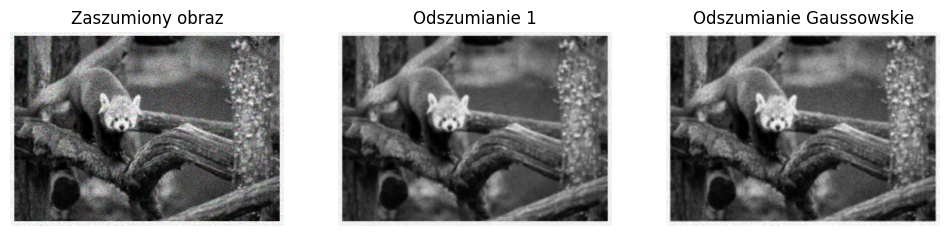

In [94]:
#rozmycie Gaussowskie 
gray_noised_image = color.rgb2gray(noised_image)
gaussian_denoised_image = filters.gaussian(gray_noised_image, sigma=1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(noised_image, cmap='gray')
plt.title('Zaszumiony obraz')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(transformed_image, cmap='gray')
plt.title('Odszumianie 1')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(gaussian_denoised_image, cmap='gray')
plt.title('Odszumianie Gaussowskie')
plt.axis('off')
plt.show()
